## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from random import sample
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from numpy import argmax


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(10)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
18718,00004968_004.png,Atelectasis|Effusion|Infiltration,4,4968,70,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_003/images/00004968_004.png
27620,00007188_008.png,Atelectasis|Effusion|Infiltration|Pneumothorax,8,7188,56,F,AP,2500,2048,0.168000,0.168000,NaN,/data/images_004/images/00007188_008.png
65968,00016291_052.png,No Finding,52,16291,54,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_008/images/00016291_052.png
92263,00023061_001.png,No Finding,1,23061,61,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_010/images/00023061_001.png
83343,00020459_001.png,No Finding,1,20459,45,F,AP,3004,2440,0.139000,0.139000,NaN,/data/images_009/images/00020459_001.png
65464,00016166_008.png,Atelectasis,8,16166,55,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_008/images/00016166_008.png
59953,00014798_012.png,Infiltration|Mass|Nodule,12,14798,23,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_007/images/00014798_012.png
9893,00002566_002.png,Infiltration,2,2566,40,F,PA,2048,2500,0.168000,0.168000,NaN,/data/images_002/images/00002566_002.png
83181,00020429_029.png,Cardiomegaly|Effusion|Emphysema|Pneumothorax,29,20429,59,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_009/images/00020429_029.png
46729,00011925_054.png,Consolidation|Infiltration,54,11925,54,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_006/images/00011925_054.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion',
                'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

for disease in disease_list:
    all_xray_df[disease] = [disease in l for l in all_xray_df['Finding Labels'].str.split('|')]

all_xray_df.sample(25)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
31570,00008252_003.png,Atelectasis|Consolidation|Nodule,3,8252,63,M,AP,2500,2048,0.168000,...,False,False,False,False,False,False,False,True,False,False
96584,00025444_011.png,Infiltration,11,25444,20,M,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,False
1337,00000347_000.png,No Finding,0,347,55,F,PA,2048,2500,0.171000,...,False,False,False,False,False,False,False,False,False,False
28858,00007534_002.png,Infiltration,2,7534,54,M,AP,2500,2048,0.168000,...,False,False,False,False,False,False,False,False,False,False
58319,00014420_000.png,No Finding,0,14420,40,F,PA,2750,2753,0.143000,...,False,False,False,False,False,False,False,False,False,False
107431,00029009_001.png,Effusion|Infiltration,1,29009,36,F,AP,3056,2544,0.139000,...,False,False,False,True,False,False,False,False,False,False
52089,00013136_000.png,No Finding,0,13136,57,F,PA,2992,2991,0.143000,...,False,False,False,False,False,False,False,False,False,False
56155,00014004_036.png,No Finding,36,14004,58,F,AP,3056,2544,0.139000,...,False,False,False,False,False,False,False,False,False,False
26776,00007007_020.png,Atelectasis|Infiltration,20,7007,45,F,AP,2500,2048,0.171000,...,False,False,False,False,False,False,False,False,False,False
86247,00021274_002.png,No Finding,2,21274,55,F,PA,2992,2991,0.143000,...,False,False,False,False,False,False,False,False,False,False


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = ['present' if x else 'not present' for x in all_xray_df.Pneumonia]
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,pneumonia_class
56666,00014093_000.png,No Finding,0,14093,39,F,PA,2530,2441,0.143000,...,False,False,False,False,False,False,False,False,False,not present
44743,00011504_013.png,No Finding,13,11504,54,M,AP,2500,2048,0.168000,...,False,False,False,False,False,False,False,False,False,not present
112076,00030773_000.png,No Finding,0,30773,10,M,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,not present
50150,00012682_000.png,No Finding,0,12682,58,F,PA,2048,2500,0.168000,...,False,False,False,False,False,False,False,False,False,not present
92665,00023128_018.png,Atelectasis|Infiltration,18,23128,28,F,PA,2586,2991,0.143000,...,False,False,False,False,False,False,False,False,False,not present


## Create your training and testing data:

In [5]:
def create_splits(d):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = skl.train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = d['pneumonia_class'])   
    
    p_inds = train_df[train_df.Pneumonia==True].index.tolist()
    np_inds = train_df[train_df.Pneumonia==False].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    print(train_df['Pneumonia'].sum()/len(train_df))
    
    
    p_inds = valid_df[valid_df.Pneumonia==True].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia==False].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = sample(np_inds,4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    
    print(valid_df['Pneumonia'].sum()/len(valid_df))

    return train_df, valid_df

In [6]:
train_data, val_data = create_splits(all_xray_df)
train_data.sample(10)

0.5
0.2


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,pneumonia_class
68207,00016822_000.png,No Finding,0,16822,40,F,PA,2658,2991,0.143000,...,False,False,False,False,False,False,False,False,False,not present
95114,00024829_000.png,No Finding,0,24829,41,F,PA,2992,2991,0.143000,...,False,False,False,False,False,False,False,False,False,not present
56214,00014014_004.png,No Finding,4,14014,20,F,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,not present
21323,00005684_001.png,No Finding,1,5684,26,M,AP,2500,2048,0.171000,...,False,False,False,False,False,False,False,False,False,not present
44214,00011386_000.png,Pneumonia,0,11386,4,M,PA,2946,2839,0.143000,...,False,False,False,True,False,False,False,False,False,present
55446,00013894_016.png,Effusion,16,13894,21,M,AP,2500,2048,0.168000,...,False,False,True,False,False,False,False,False,False,not present
64062,00015809_014.png,Pneumonia,14,15809,38,F,AP,3056,2544,0.139000,...,False,False,False,True,False,False,False,False,False,present
85322,00021035_006.png,Edema|Infiltration|Pneumonia,6,21035,34,M,AP,3056,2544,0.139000,...,False,False,False,True,False,False,False,False,False,present
78166,00019176_076.png,Pneumonia,76,19176,66,F,AP,3056,2544,0.139000,...,False,False,False,True,False,False,False,False,False,present
43413,00011193_004.png,Nodule,4,11193,55,F,PA,2610,2941,0.143000,...,False,False,False,False,False,False,True,False,False,not present


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation(df, t):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    if (t == 'train'):
        return ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=10, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                                 preprocessing_function=preprocess_input)
    else:
        return ImageDataGenerator(rescale=1. / 255.0,
                                 preprocessing_function=preprocess_input)


def make_train_gen(df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation(df, 'train')
    train_gen = my_train_idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224, 224), 
                                         batch_size = 64
                                         )
    return train_gen


def make_val_gen(df):
    
    my_val_idg = my_image_augmentation(df, 'val')
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                            directory=None, 
                                            x_col = 'path',
                                            y_col = 'pneumonia_class',
                                            class_mode = 'binary',
                                            target_size = (224, 224), 
                                            batch_size = 1430
                                            ) 
    
    # Todo
    return val_gen

In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [42]:
train_gen = make_train_gen(train_data)

Found 2290 validated image filenames belonging to 2 classes.


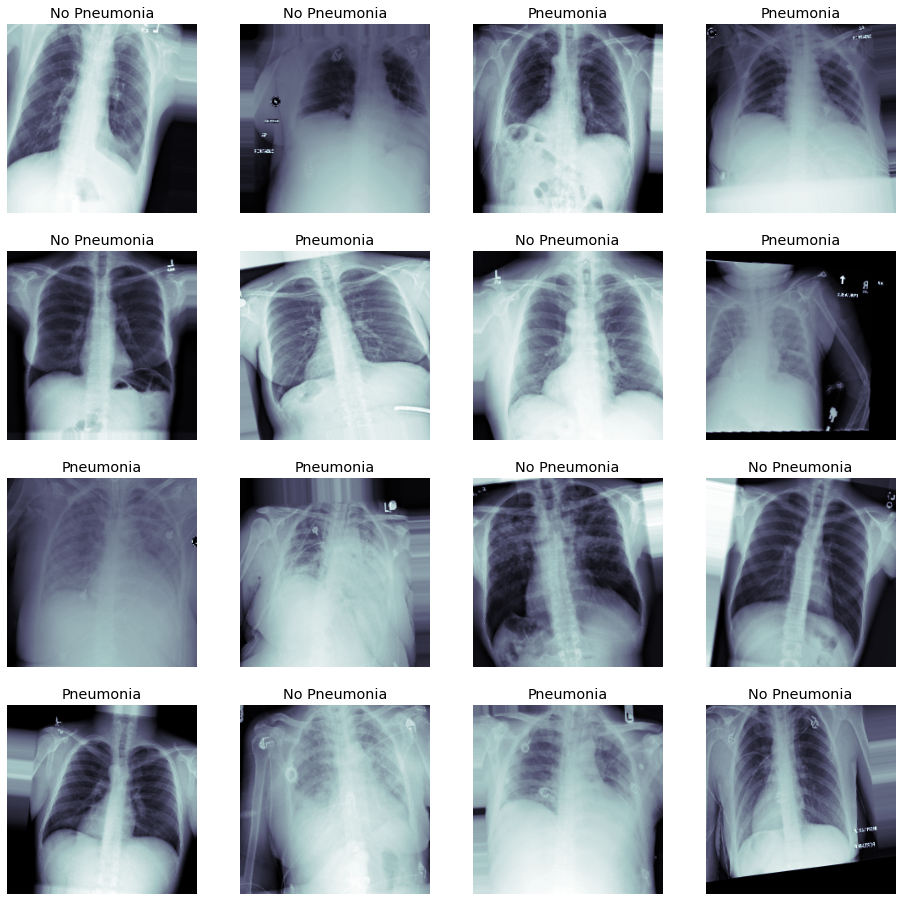

In [43]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    model.summary()

    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                       outputs=transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
#    for layer in vgg_model.layers:
#        print(layer.name, layer.trainable)
    
    return vgg_model


In [54]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(load_pretrained_model())

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())
    my_model.add(Dropout(0.2))
        
    my_model.add(Dense(1, activation='sigmoid'))

    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=0.001)
    loss = 'binary_crossentropy'
#    metrics = ['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]   
    
    metrics = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)    
        
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [55]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_binary_accuracy'
CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC = 'max'

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                             save_weights_only = True)

early = EarlyStopping(monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                      mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [56]:
## train your model

# Todo

my_model = build_my_model()
## Just run a single epoch to see how it does:
# my_model.fit_generator(train_gen, 
#                       validation_data = (valX, valY), 
#                       epochs = 1)    



history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     


Epoch 00016: val_binary_accuracy improved from 0.62301 to 0.62588, saving model to xray_class_my_model.best.hdf5
Epoch 17/20
36/36 [==============================] - 990s 28s/step - loss: 0.5912 - binary_accuracy: 0.6270 - precision: 0.5150 - recall: 0.6257 - val_loss: 0.6014 - val_binary_accuracy: 0.6283 - val_precision: 0.5159 - val_recall: 0.6256

Epoch 00017: val_binary_accuracy improved from 0.62588 to 0.62833, saving model to xray_class_my_model.best.hdf5
Epoch 18/20
36/36 [==============================] - 997s 28s/step - loss: 0.5916 - binary_accuracy: 0.6299 - precision: 0.5178 - recall: 0.6272 - val_loss: 0.5739 - val_binary_accuracy: 0.6317 - val_precision: 0.5194 - val_recall: 0.6277

Epoch 00018: val_binary_accuracy improved from 0.62833 to 0.63171, saving model to xray_class_my_model.best.hdf5
Epoch 19/20
36/36 [==============================] - 1019s 28s/step - loss: 0.5895 - binary_accuracy: 0.6335 - precision: 0.5215 - recall: 0.6280 - val_loss: 0.6424 - val_binary_ac

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [64]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize=(18,18))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower right")

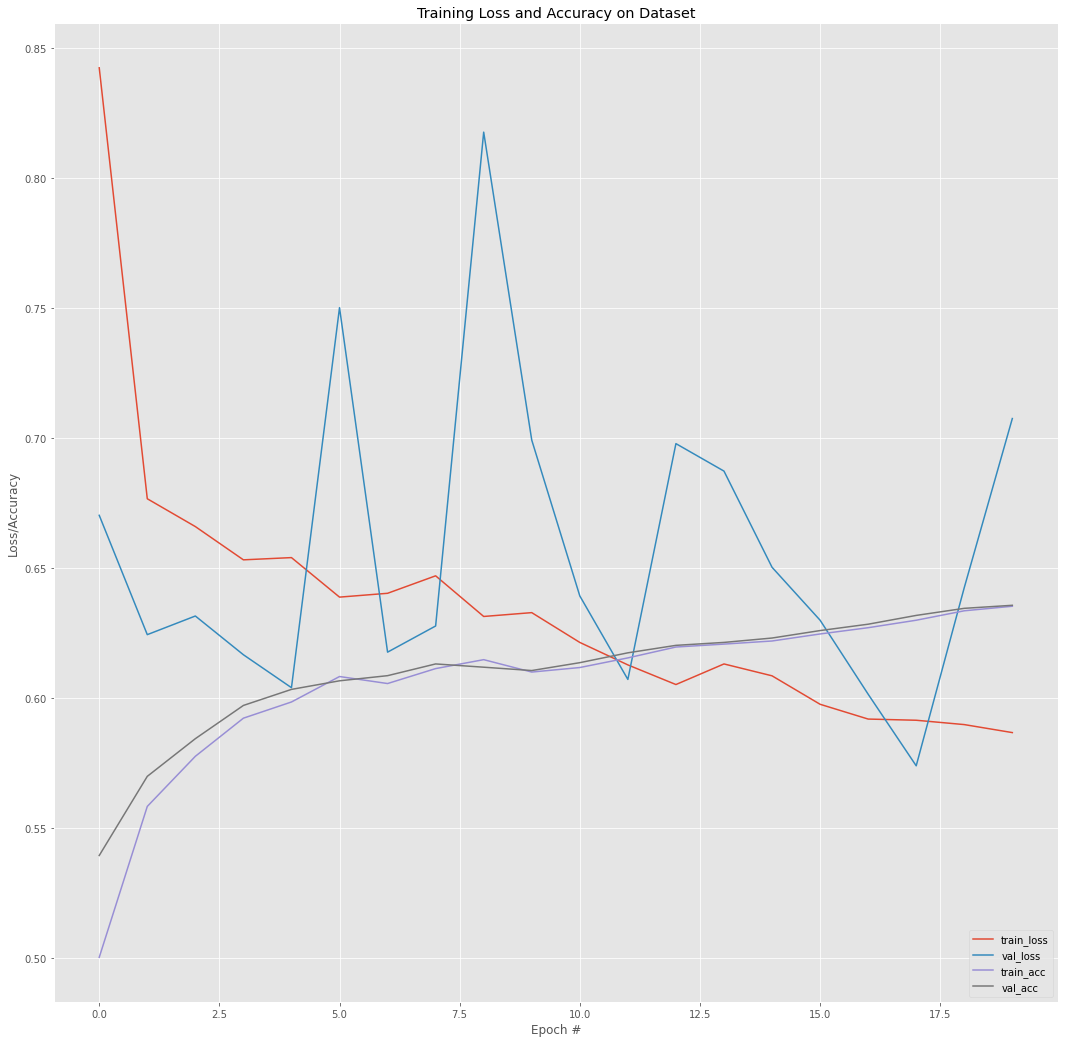

In [65]:
plot_history(history)

In [61]:
history

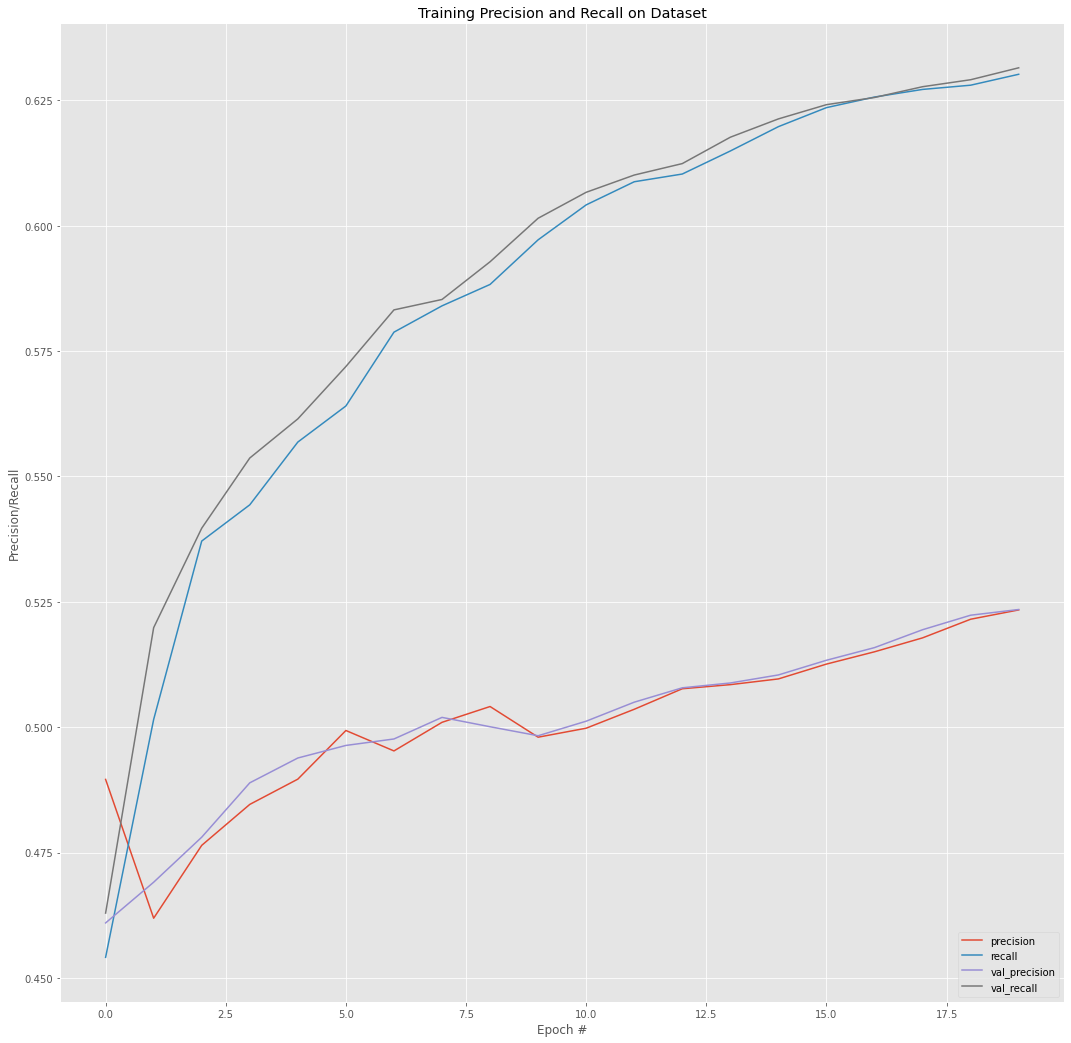

In [63]:
N = len(history.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize=(18,18))
plt.plot(np.arange(0, N), history.history["precision"], label="precision")
plt.plot(np.arange(0, N), history.history["recall"], label="recall")
plt.plot(np.arange(0, N), history.history["val_precision"], label="val_precision")
plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
plt.title("Training Precision and Recall on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower right")

# Model Evaluation

In [11]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model = Sequential()
my_model.add(load_pretrained_model())
my_model.add(Flatten())
my_model.add(Dropout(0.2))
my_model.add(Dense(1, activation='sigmoid'))
    
weight_path="{}_my_model.best.hdf5".format('xray_class')

my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [20]:
print(pred_Y)
print(valY)

[[0.8357316 ]
 [0.35785702]
 [0.701067  ]
 ...
 [0.41093352]
 [0.56752706]
 [0.4363057 ]]
[1. 0. 1. ... 0. 1. 1.]


In [78]:
predY = (pred_Y > 0.5).astype(np.int)
print(accuracy_score(valY, predY))
print(f1_score(valY, predY))
print(confusion_matrix(valY, predY))

0.6090909090909091
0.4231166150670794
[[666 478]
 [ 81 205]]


In [118]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    ## https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return

def plot_precision_recall(t_y, p_y):
    ## https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
    
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(t_y[t_y==1]) / len(t_y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(t_y, p_y)
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label='model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()    

    return

def plot_f1(t_y, p_y):
    
    f1_scores = []
    thresholds = []
    for p in np.arange(0.10, 0.90, 0.01):
        predY = (p_y > p).astype(np.int)
        f1_scores.append(f1_score(valY, predY))
        thresholds.append(p)
        
    ix = argmax(f1_scores)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f1_scores[ix]))
    
    plt.plot(thresholds, f1_scores)
    plt.scatter(thresholds[ix], f1_scores[ix], marker='o', color='black', label='Best')
    plt.show()
    return

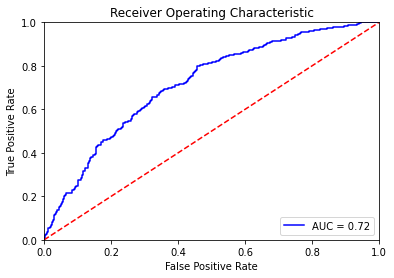

In [119]:
## plot figures

# Todo
plot_auc(valY, pred_Y)

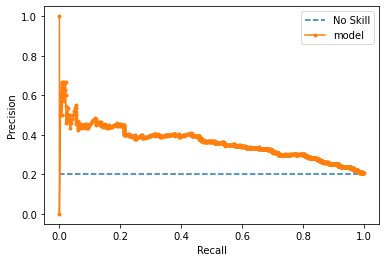

In [120]:
plot_precision_recall(valY, pred_Y)

Best Threshold=0.550000, F-Score=0.443


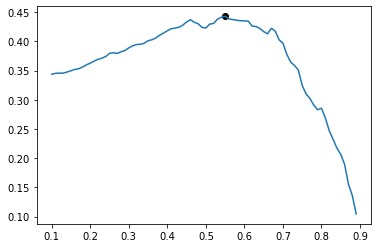

In [121]:
plot_f1(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [128]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

## I want to minimze the the number of patients with pneumonia that the model predicts do not have pneumonia
## Therefore instead of taking the threshold that maximizes the f-score, I will take the threshold of the second peak
## Thus reducing the number of patients labeled without pneumonia that actually have pneumonia

YOUR_THRESHOLD = 0.46
predY = (pred_Y > YOUR_THRESHOLD).astype(np.int)
print(accuracy_score(valY, predY))
print(f1_score(valY, predY))
print(confusion_matrix(valY, predY))

0.5895104895104896
0.43720038350910834
[[615 529]
 [ 58 228]]


In [31]:
YOUR_THRESHOLD = 0.46
predY = (pred_Y > YOUR_THRESHOLD).astype(np.int)

tn, fp, fn, tp = confusion_matrix(valY, predY,labels=[0,1]).ravel()

In [32]:
sens = tp/(tp+fn)
sens

0.7902097902097902

In [33]:
spec = tn/(tn+fp)
spec

0.5384615384615384

In [34]:
prec = tp/(tp+fp)
prec

0.29973474801061006

In [22]:
data = val_data
data['algorithm_output'] = predY
data.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,pneumonia_class,algorithm_output
34128,00008934_000.png,No Finding,0,8934,40,M,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,not present,0
824,00000200_000.png,Nodule,0,200,75,M,PA,2500,2048,0.168,...,False,False,False,False,False,True,False,False,not present,0
57136,00014188_000.png,No Finding,0,14188,20,M,PA,2338,2905,0.143,...,False,False,False,False,False,False,False,False,not present,0
94807,00024533_000.png,No Finding,0,24533,60,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,not present,1
100636,00026713_015.png,Consolidation|Effusion|Pneumonia,15,26713,62,F,AP,3056,2544,0.139,...,False,True,True,False,False,False,False,False,present,1
37740,00009925_038.png,Infiltration|Pneumonia,38,9925,56,M,PA,2992,2991,0.143,...,False,False,True,False,False,False,False,False,present,1
9648,00002505_018.png,No Finding,18,2505,28,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,not present,1
11575,00003028_078.png,No Finding,78,3028,58,F,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,not present,1
36467,00009609_008.png,Infiltration,8,9609,52,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,not present,1
27897,00007270_000.png,No Finding,0,7270,52,M,PA,2500,2048,0.171,...,False,False,False,False,False,False,False,False,not present,1


In [28]:
disease_list_wo = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion',
                'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

tn, fp, fn, tp = confusion_matrix(data[data[disease_list_wo].sum(axis=1) == 0].Pneumonia.values,
                                                  data[data[disease_list_wo].sum(axis=1) == 0].algorithm_output.values,labels=[0,1]).ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)
prec = tp/(tp+fp)

print('Sensitivity: '+ str(sens))
print('Specificity: ' +str(spec))
print('Precision: ' +str(prec))
print()

Sensitivity: 0.5846153846153846
Specificity: 0.4889937106918239
Precision: 0.1046831955922865



In [29]:
# Review performnance in the presence of other diseases
# In medical diagnosis, test sensitivity is the ability of a test to correctly 
# identify those with the disease (true positive rate), 
# whereas test specificity is the ability of the test to correctly identify those without the disease (true negative rate).

for i in disease_list_wo:

    tn, fp, fn, tp = confusion_matrix(data[data[i]==1].Pneumonia.values,
                                                  data[data[i]==1].algorithm_output.values,labels=[0,1]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    prec = tp/(tp+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))
    print('Precision: ' +str(prec))
    print()

Atelectasis
Sensitivity: 0.5384615384615384
Specificity: 0.4727272727272727
Precision: 0.32558139534883723

Consolidation
Sensitivity: 0.52
Specificity: 0.42
Precision: 0.30952380952380953

Infiltration
Sensitivity: 0.5040650406504065
Specificity: 0.41081081081081083
Precision: 0.36257309941520466

Pneumothorax
Sensitivity: 0.8333333333333334
Specificity: 0.4074074074074074
Precision: 0.13513513513513514

Edema
Sensitivity: 0.509090909090909
Specificity: 0.4666666666666667
Precision: 0.7777777777777778

Emphysema
Sensitivity: 0.6
Specificity: 0.375
Precision: 0.16666666666666666

Fibrosis
Sensitivity: 0.4
Specificity: 0.5
Precision: 0.18181818181818182

Effusion
Sensitivity: 0.5686274509803921
Specificity: 0.46099290780141844
Precision: 0.2761904761904762

Pleural_Thickening
Sensitivity: 0.5833333333333334
Specificity: 0.5428571428571428
Precision: 0.30434782608695654

Cardiomegaly
Sensitivity: 0.5454545454545454
Specificity: 0.45161290322580644
Precision: 0.2608695652173913

Nodule
Se

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


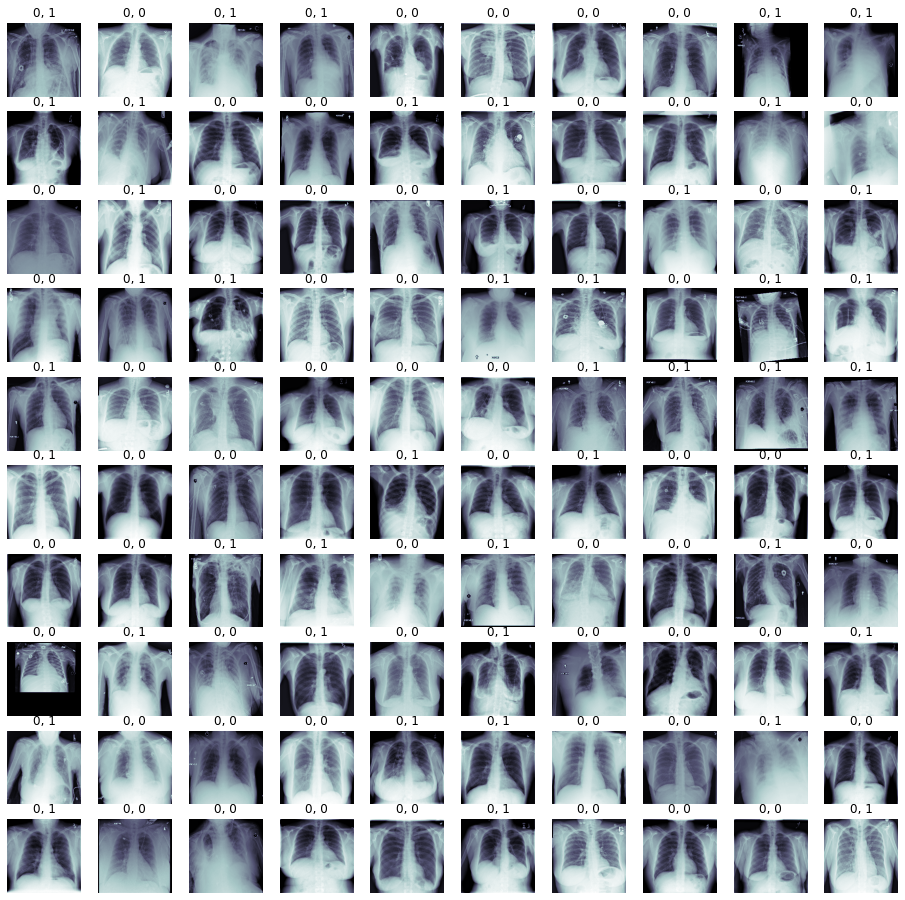

In [123]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
testY = pred_Y

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [124]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)